In [1]:
# Scrape Farsight "Publication Dates" page, download transcripts,
# and capture section, title, title link, publication date, download link.

import os, time, hashlib, csv, re
from urllib.parse import urljoin, urlparse
import requests
from bs4 import BeautifulSoup

BASE_URL   = "https://farsight.org"
PAGE_URL   = "https://farsight.org/FarsightPress/Publication_Dates_for_Farsight_Projects"
OUT_DIR    = "C:/datasources/farsight_transcripts"
LOG_CSV    = os.path.join(OUT_DIR, "download_log.csv")

# --- settings ---
TIMEOUT_S      = 30
RETRY_N        = 3
SLEEP_BETWEEN  = 0.8
HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; farsight-transcript-harvester/1.0)"}

os.makedirs(OUT_DIR, exist_ok=True)

def get_soup(url):
    r = requests.get(url, headers=HEADERS, timeout=TIMEOUT_S)
    r.raise_for_status()
    return BeautifulSoup(r.text, "html.parser")

def sha256_bytes(b):
    h = hashlib.sha256()
    h.update(b)
    return h.hexdigest()

def sanitize_filename(path_part):
    name = path_part.strip().split("?")[0].split("#")[0]
    name = os.path.basename(name)
    if not name.lower().endswith(".txt"):
        name += ".txt"
    return re.sub(r"[^-\w. ]", "_", name)[:200]

DATE_RE = re.compile(
    r"(\b\d{4}-\d{2}-\d{2}\b|"                       # 2024-09-01
    r"\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Sept|Oct|Nov|Dec)[a-z]*\s+\d{1,2},\s*\d{4}\b|"  # Sep 1, 2025
    r"\b\d{1,2}/\d{1,2}/\d{2,4}\b)",                # 9/1/2025
    re.IGNORECASE
)

def find_section(node):
    # Walk backwards in the DOM to find the nearest H1/H2/H3
    for prev in node.find_all_previous():
        if prev.name in ("h1", "h2", "h3"):
            t = prev.get_text(" ", strip=True)
            if t:
                return t
    return ""

def extract_from_row(download_a):
    """
    Try to resolve metadata (title, title_url, pub_date, section) from a table row context.
    Fallbacks if structure is different.
    """
    section = find_section(download_a)
    title, title_url, pub_date = "", "", ""

    # Prefer an ancestor <tr> if present (most likely)
    tr = download_a.find_parent("tr")
    if tr:
        tds = tr.find_all("td")
        # Try to find a title link in the first or any td
        title_link = None
        candidates = tds[0:2] if len(tds) >= 1 else tds
        for td in candidates:
            alink = td.find("a", href=True)
            if alink and alink.get_text(strip=True):
                title_link = alink
                break
        if title_link:
            title = title_link.get_text(" ", strip=True)
            title_url = urljoin(PAGE_URL, title_link["href"])

        # Publication date heuristics: check the second cell then the row text
        if len(tds) >= 2:
            m = DATE_RE.search(tds[1].get_text(" ", strip=True))
            if m:
                pub_date = m.group(1)
        if not pub_date:
            m = DATE_RE.search(tr.get_text(" ", strip=True))
            if m:
                pub_date = m.group(1)
        return section, title, title_url, pub_date

    # If not inside a row, try a nearby block
    parent = download_a.find_parent(["p","div","li"]) or download_a.parent
    text_blob = parent.get_text(" ", strip=True) if parent else ""
    m = DATE_RE.search(text_blob)
    if m:
        pub_date = m.group(1)

    # Look for the nearest title-like link before the download link
    title_link = None
    for prev in download_a.find_all_previous("a", href=True, limit=10):
        # Skip other downloads; prefer links with meaningful text
        if prev.get_text(strip=True).lower() == "download":
            continue
        if prev.find_parent("tr") == download_a.find_parent("tr"):
            title_link = prev
            break
        # Otherwise, pick the first decent candidate
        if not title_link and prev.get_text(strip=True):
            title_link = prev

    if title_link:
        title = title_link.get_text(" ", strip=True)
        title_url = urljoin(PAGE_URL, title_link["href"])

    return section, title, title_url, pub_date

def download(url, out_path):
    for attempt in range(1, RETRY_N + 1):
        try:
            with requests.get(url, headers=HEADERS, timeout=TIMEOUT_S, stream=True) as r:
                r.raise_for_status()
                data = r.content
            digest = sha256_bytes(data)
            with open(out_path, "wb") as f:
                f.write(data)
            return digest, len(data), None
        except Exception as e:
            if attempt < RETRY_N:
                time.sleep(1.5 * attempt)
            else:
                return None, 0, str(e)

# --- scrape the page ---
soup = get_soup(PAGE_URL)

# Find all "Download" links (and also any direct .txt links as a backup)
candidates = []
for a in soup.find_all("a", href=True):
    text = (a.get_text() or "").strip().lower()
    href = a["href"].strip()
    abs_url = urljoin(PAGE_URL, href)
    if text == "download" or abs_url.lower().endswith(".txt"):
        candidates.append((a, abs_url))

# Deduplicate by absolute-url while preserving the FIRST occurrence (keeps best context)
seen = set()
link_nodes = []
for a, u in candidates:
    # Only consider transcript .txt links
    if not u.lower().endswith(".txt"):
        continue
    if u in seen:
        continue
    seen.add(u)
    link_nodes.append((a, u))

print(f"Found {len(link_nodes)} transcript links to fetch.")

# --- download and log ---
rows = []
for i, (a_node, dl_url) in enumerate(link_nodes, 1):
    section, title, title_url, pub_date = extract_from_row(a_node)

    fname = sanitize_filename(urlparse(dl_url).path)
    out_path = os.path.join(OUT_DIR, fname)
    print(f"[{i}/{len(link_nodes)}] {section or '(no section)'} → {title or fname}")

    digest, nbytes, err = download(dl_url, out_path)
    status = "ok" if err is None else "error"
    if status == "ok":
        print(f"  -> saved {nbytes/1024:.1f} KB, sha256={digest[:12]}…")
    else:
        print(f"  xx error: {err}")

    rows.append({
        "section": section,
        "title": title,
        "title_url": title_url,
        "publication_date": pub_date,
        "download_url": dl_url,
        "file": fname,
        "bytes": nbytes,
        "sha256": digest or "",
        "status": status,
        "error": err or "",
    })
    time.sleep(SLEEP_BETWEEN)

# Write CSV log (UTF-8)
fieldnames = [
    "section", "title", "title_url", "publication_date",
    "download_url", "file", "bytes", "sha256", "status", "error"
]
with open(LOG_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=fieldnames)
    w.writeheader()
    w.writerows(rows)

print(f"\nDone. Files are in: {OUT_DIR}\nLog: {LOG_CSV}")


Found 140 transcript links to fetch.
[1/140] (no section) → Front_end_for_Farsight_Mysteries_Vault.txt
  -> saved 29.0 KB, sha256=a26bc311cbe6…
[2/140] (no section) → Tower of Babel
  -> saved 112.0 KB, sha256=fab6a159bf40…
[3/140] (no section) → The Seraphim
  -> saved 103.7 KB, sha256=5d7fc6dfe63f…
[4/140] (no section) → The Rendlesham UFO Incident
  -> saved 94.1 KB, sha256=7081da61f097…
[5/140] (no section) → Pine Gap Base
  -> saved 113.7 KB, sha256=40fffcdb912e…
[6/140] (no section) → Kailasa Temple: Mystery of Construction
  -> saved 103.6 KB, sha256=f0773361e668…
[7/140] (no section) → Maintaining the Death Traps
  -> saved 102.7 KB, sha256=af23b7fa1ed6…
[8/140] (no section) → Young Jesus
  -> saved 100.7 KB, sha256=97b89112ddb9…
[9/140] (no section) → ET Shootout Preparations
  -> saved 87.0 KB, sha256=7de5d291b9b3…
[10/140] (no section) → TWA Flight 800
  -> saved 87.0 KB, sha256=4b9a345c96f2…
[11/140] (no section) → ET PSYOP
  -> saved 152.3 KB, sha256=ca73361a928d…
[12/140]

[92/140] (no section) → Zeus
  -> saved 121.2 KB, sha256=00875b6f1103…
[93/140] (no section) → Human Leadership Has Been Compromised
  -> saved 41.7 KB, sha256=b4c91d53f4e5…
[94/140] (no section) → Where We Came From
  -> saved 82.2 KB, sha256=c115bccd754b…
[95/140] (no section) → The Death Traps
  -> saved 82.7 KB, sha256=1741f04308d2…
[96/140] (no section) → Oumuamua and the Bird of Prey
  -> saved 90.3 KB, sha256=9746498aad9d…
[97/140] (no section) → Secret Apollo Moon Missions
  -> saved 78.6 KB, sha256=ec1bc906b753…
[98/140] (no section) → Moses Beyond Exodus
  -> saved 103.5 KB, sha256=81faebcbe5d0…
[99/140] (no section) → War In Heaven
  -> saved 103.3 KB, sha256=c865e92f98b9…
[100/140] (no section) → Tunguska
  -> saved 93.4 KB, sha256=386c495fa327…
[101/140] (no section) → Area 51
  -> saved 74.6 KB, sha256=cde9c7f8027e…
[102/140] (no section) → Roswell UFO Crash
  -> saved 107.1 KB, sha256=77d8488d2a8c…
[103/140] (no section) → Martin Luther King, Jr.
  -> saved 48.5 KB, sha2

In [3]:
import os, re, glob
from pathlib import Path
from typing import List, Tuple, Dict
import pandas as pd

# --- Paths ---
ROOT_DIR = Path(r"C:\datasources\farsight_transcripts")
OUT_CSV  = ROOT_DIR / "farsight_chunks.csv"
SCRAPE_LOG = ROOT_DIR / "download_log.csv"  # optional (from earlier scrape)

# --- Regex per legend ---
RE_TITLE_LINE     = re.compile(r"^\*{6}\s*(.*?)\s*\*{6}\s*$", re.IGNORECASE | re.MULTILINE)
RE_OVERVIEW_START = re.compile(r"^%{6}\s*PROJECT OVERVIEW\s*%{6}\s*$", re.IGNORECASE | re.MULTILINE)
RE_OVERVIEW_BLK   = re.compile(
    r"^%{6}\s*PROJECT OVERVIEW\s*%{6}\s*$"      # start
    r"(.*?)"
    r"^%{6}\s*END PROJECT OVERVIEW\s*%{6}\s*$", # end
    re.IGNORECASE | re.MULTILINE | re.DOTALL
)
RE_BEGIN_SESSIONS = re.compile(r"^=+\s*BEGIN SESSIONS\s*=+\s*$", re.IGNORECASE | re.MULTILINE)
RE_SESSION_HEADER = re.compile(r"^=+\s*(.*?)\s+SESSION\s*$", re.IGNORECASE | re.MULTILINE)
RE_END_PROJECT    = re.compile(r"^&{6}\s*END OF .*?\*{6}\s*$", re.IGNORECASE | re.MULTILINE)

def read_text(path: Path) -> str:
    for enc in ("utf-8", "utf-8-sig", "cp1252", "latin-1"):
        try:
            return path.read_text(encoding=enc)
        except Exception:
            continue
    return path.read_text(encoding="utf-8", errors="replace")

def extract_title(text: str) -> str:
    m = RE_TITLE_LINE.search(text)
    return m.group(1).strip() if m else ""

def extract_targets(text: str) -> str:
    """
    Targets are listed immediately below the title.
    Heuristic: capture non-empty lines after the title until a blank line
    OR a known separator (overview/sessions/end/title again).
    """
    m = RE_TITLE_LINE.search(text)
    if not m:
        return ""
    start = m.end()
    tail = text[start:]
    lines = tail.splitlines()

    out = []
    for ln in lines:
        if not ln.strip():
            # stop on the first blank line after we started collecting (if we started)
            if out:
                break
            else:
                continue
        if (RE_TITLE_LINE.match(ln) or RE_OVERVIEW_START.match(ln) or
            RE_BEGIN_SESSIONS.match(ln) or RE_END_PROJECT.match(ln)):
            break
        # Avoid picking up decorative/separator lines
        if re.fullmatch(r"[-=*_/\\]{3,}", ln.strip()):
            continue
        out.append(ln.strip())

        # safety: don't accidentally slurp a huge block
        if len(out) >= 30:   # targets should be short; cap at 30 lines
            break

    # Trim trailing lines that look like headers/separators
    while out and not out[-1]:
        out.pop()

    return "\n".join(out).strip()

def extract_overview(text: str) -> str:
    m = RE_OVERVIEW_BLK.search(text)
    if not m:
        return ""
    body = m.group(1)
    body = re.sub(r"\n{3,}", "\n\n", body).strip()
    return body

def extract_sessions(text: str) -> List[Tuple[str, str]]:
    mstart = RE_BEGIN_SESSIONS.search(text)
    start = mstart.end() if mstart else 0
    mend = RE_END_PROJECT.search(text[start:]) if start is not None else None
    end_idx = start + mend.start() if (mend and start is not None) else len(text)
    region = text[start:end_idx]

    headers = list(RE_SESSION_HEADER.finditer(region))
    sessions = []
    if not headers:
        body = region.strip()
        if body:
            sessions.append(("", body))
        return sessions

    for i, h in enumerate(headers):
        viewer = (h.group(1) or "").strip()
        body_start = h.end()
        body_end = headers[i+1].start() if i + 1 < len(headers) else len(region)
        body = region[body_start:body_end].strip()
        body = re.sub(r"^=+\s*$", "", body, flags=re.MULTILINE)
        body = re.sub(r"\n{3,}", "\n\n", body)
        sessions.append((viewer, body))
    return sessions

def build_relevant_text(text: str) -> Tuple[str, str, str]:
    """
    Return (targets, overview, sessions_text)
    sessions_text is all session bodies with lightweight labels.
    """
    targets = extract_targets(text)
    overview = extract_overview(text)

    session_parts = []
    for viewer, body in extract_sessions(text):
        label = f"Session ({viewer}):" if viewer else "Session:"
        session_parts.append(label + "\n" + body.strip())
    sessions_text = "\n\n".join(session_parts).strip()

    return targets, overview, sessions_text

# --- Chunking: 400-word windows with 50-word overlap.
# Last window is back-shifted to end exactly at the document end while keeping 400 words when possible.
def tokenize_words(s: str) -> List[str]:
    return re.findall(r"\S+", s)

def join_words(ws: List[str]) -> str:
    return " ".join(ws)

def chunk_words_fixed(text: str, chunk_size=400, overlap=50) -> List[Tuple[int, int, str]]:
    ws = tokenize_words(text)
    n = len(ws)
    if n == 0:
        return []
    if n <= chunk_size:
        return [(0, n, join_words(ws))]

    step = max(1, chunk_size - overlap)
    starts = list(range(0, n - chunk_size + 1, step))
    last_start = n - chunk_size
    if not starts or starts[-1] != last_start:
        starts.append(last_start)  # back-shift tail to keep a full-size chunk

    chunks = []
    for s in starts:
        e = min(n, s + chunk_size)
        chunks.append((s, e, join_words(ws[s:e])))
    return chunks

# --- Optional: bring in metadata from prior scrape
def load_metadata(log_path: Path) -> Dict[str, Dict[str, str]]:
    mapping = {}
    if not log_path.exists():
        return mapping
    df = pd.read_csv(log_path)
    for _, row in df.iterrows():
        fname = str(row.get("file", "")).strip()
        if not fname:
            continue
        mapping[fname.lower()] = {
            "section": row.get("section", "") if pd.notna(row.get("section", "")) else "",
            "title": row.get("title", "") if pd.notna(row.get("title", "")) else "",
            "title_url": row.get("title_url", "") if pd.notna(row.get("title_url", "")) else "",
            "publication_date": row.get("publication_date", "") if pd.notna(row.get("publication_date", "")) else "",
        }
    return mapping

meta_map = load_metadata(SCRAPE_LOG)

# --- Build dataframe ---
rows = []
txt_files = sorted(ROOT_DIR.glob("*.txt"))

for path in txt_files:
    raw = read_text(path)
    targets, overview, sessions_text = build_relevant_text(raw)

    # Compose the "relevant" corpus: Targets + Overview + Sessions
    parts = []
    if targets:
        parts.append("Targets:\n" + targets)
    if overview:
        parts.append("Overview:\n" + overview)
    if sessions_text:
        parts.append(sessions_text)
    relevant = "\n\n".join(parts).strip()

    meta = meta_map.get(path.name.lower(), {})
    title_from_file = extract_title(raw)

    section = meta.get("section", "")
    title = meta.get("title", "") or title_from_file
    title_url = meta.get("title_url", "")
    pub_date  = meta.get("publication_date", "")

    file_chunks = chunk_words_fixed(relevant, chunk_size=400, overlap=50)

    for idx, (start, end, chunk_text) in enumerate(file_chunks):
        rows.append({
            "file": path.name,
            "section": section,
            "title": title,
            "title_url": title_url,
            "publication_date": pub_date,
            "targets": targets,                 # included as a column for convenience
            "chunk_index": idx,
            "start_word": start,
            "end_word": end,
            "chunk_words": end - start,
            "chunk_text": chunk_text
        })

df = pd.DataFrame(rows, columns=[
    "file","section","title","title_url","publication_date","targets",
    "chunk_index","start_word","end_word","chunk_words","chunk_text"
])

# Remove any literal "|" inside text fields
for col in ["targets", "chunk_text", "title", "section"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace("|", "", regex=False)

# Save to CSV with "|" as delimiter
OUT_PIPE = ROOT_DIR / "farsight_chunks_pipe.csv"
df.to_csv(OUT_PIPE, index=False, sep="|", encoding="utf-8")

print(f"Wrote {len(df)} rows to {OUT_PIPE} with '|' as delimiter.")

# IPFS CID bafybeiayo3elqakf5zskjv6l4ie6fjnh53r6uxqtx22zq6jdwxtcizlpby

Wrote 5155 rows to C:\datasources\farsight_transcripts\farsight_chunks_pipe.csv with '|' as delimiter.


In [4]:
df.head(5)

,file,section,title,title_url,publication_date,targets,chunk_index,start_word,end_word,chunk_words,chunk_text
0,911_Part_1_FULL_TEXT.txt,,"9/11 Project, 2 parts",https://farsight.org/demo/Mysteries/Mysteries_...,,TARGETS FOR 911 PART 1 - NEW YORK ATTACKS PROJ...,0,0,400,400,Targets: TARGETS FOR 911 PART 1 - NEW YORK ATT...
1,911_Part_1_FULL_TEXT.txt,,"9/11 Project, 2 parts",https://farsight.org/demo/Mysteries/Mysteries_...,,TARGETS FOR 911 PART 1 - NEW YORK ATTACKS PROJ...,1,350,750,400,torque. And this is when I see this. It's very...
2,911_Part_1_FULL_TEXT.txt,,"9/11 Project, 2 parts",https://farsight.org/demo/Mysteries/Mysteries_...,,TARGETS FOR 911 PART 1 - NEW YORK ATTACKS PROJ...,2,700,1100,400,this. Although it's kind of shaped like this. ...
3,911_Part_1_FULL_TEXT.txt,,"9/11 Project, 2 parts",https://farsight.org/demo/Mysteries/Mysteries_...,,TARGETS FOR 911 PART 1 - NEW YORK ATTACKS PROJ...,3,1050,1450,400,probably an important clue as to what actually...
4,911_Part_1_FULL_TEXT.txt,,"9/11 Project, 2 parts",https://farsight.org/demo/Mysteries/Mysteries_...,,TARGETS FOR 911 PART 1 - NEW YORK ATTACKS PROJ...,4,1400,1800,400,get rid of this first. So we have tendency. An...


In [5]:
# Save DataFrame to JSON (line-delimited or records-based)
OUT_JSON = ROOT_DIR / "farsight_chunks.json"

# Use 'records' for a list of row objects; orient="records" is common for downstream use
df.to_json(OUT_JSON, orient="records", force_ascii=False, indent=2)

print(f"Wrote {len(df)} rows to {OUT_JSON}")

# IPFS CID bafybeig66qdfmnom2vkbr33ro2rby6nyak4tucr4nivw27cjd4jxeummmu

Wrote 5155 rows to C:\datasources\farsight_transcripts\farsight_chunks.json


In [7]:
# pip install pandas numpy
import json, math, re
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

STOP = set(("a an and are as at be but by for from has have in into is it its "
            "of on or over such that the their then there these this to was "
            "were will with without i you he she they we them his her our your "
            "my mine ours yours theirs not no yes do did done what when where "
            "who why how which").split())

def tok(s):
    return [w.lower() for w in re.findall(r"[A-Za-z0-9]+", s or "") if len(w) >= 2 and w.lower() not in STOP]

TFIDF_WEIGHTS = {"chunk_text":1.0, "title":2.0, "section":1.0}

# Load your JSON
rows = pd.read_json("C:\\datasources\\farsight_transcripts\\farsight_chunks.json", orient="records").to_dict("records")
N = len(rows)
df = Counter()
perdoc = []

# pass 1: counts + df
for r in rows:
    counts = Counter()
    seen = set()
    for field, w in TFIDF_WEIGHTS.items():
        for t in tok(r.get(field, "")):
            counts[t] += w
            if t not in seen:
                df[t] += 1
                seen.add(t)
    perdoc.append(counts)

# idf
idf = {t: math.log((N+1)/(df[t]+1)) + 1.0 for t in df}

# pass 2: tf-idf normalized + postings
vocab = sorted(df.keys())
index = {t: [] for t in vocab}
for i, counts in enumerate(perdoc):
    weights = {}
    for t, tf in counts.items():
        tw = 1 + math.log(tf)
        w = tw * idf[t]
        if w > 0:
            weights[t] = w
    norm = math.sqrt(sum(v*v for v in weights.values())) or 1.0
    for t, w in weights.items():
        index[t].append([i, w / norm])  # id, normalized weight

# pack compactly
offsets = [0]
flat_ids = []
flat_wts = []
for t in vocab:
    postings = index[t]
    flat_ids.extend([p[0] for p in postings])
    flat_wts.extend([p[1] for p in postings])
    offsets.append(len(flat_ids))

out = {
    "vocab": vocab,
    "idf": [idf[t] for t in vocab],
    "offsets": offsets,
    "docIds": flat_ids,
    "weights": flat_wts,
    "docCount": N,
}
with open("C:\\datasources\\farsight_transcripts\\tfidf_index.json", "w", encoding="utf-8") as f:
    json.dump(out, f, ensure_ascii=False)
print("Wrote tfidf_index.json")
# IPFS CID bafybeigenv42ihgthvzs2bgjiyzx5iixqbuemqrxrjp3j3udgyknhetjxy

Wrote tfidf_index.json


Using font: C:\\Windows\\Fonts\\segoeui.ttf exists? True


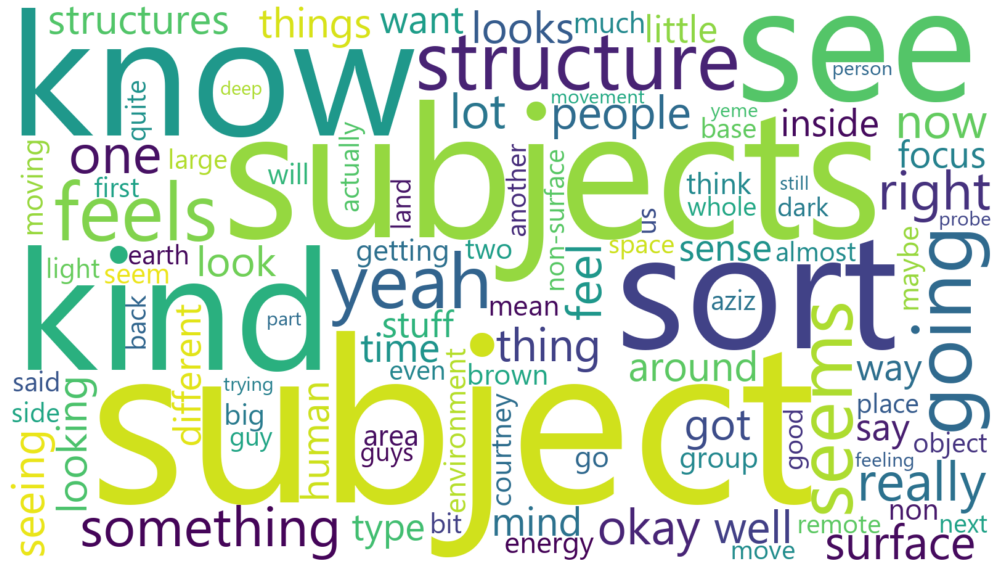

Saved word cloud → C:\datasources\farsight_transcripts\farsight_top100_wordcloud.png


In [1]:
import re
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib

JSON_PATH = Path(r"C:\\datasources\\farsight_transcripts\\farsight_chunks.json")
TOP_N = 100

# Load JSON (array vs NDJSON)
def load_chunks_json(path: Path) -> pd.DataFrame:
    head = path.read_text(encoding="utf-8", errors="ignore")[:256].lstrip()
    if head.startswith("["):
        return pd.read_json(path, orient="records")
    else:
        return pd.read_json(path, orient="records", lines=True)

df = load_chunks_json(JSON_PATH)

# Tokenization + counts
STOP = set(STOPWORDS) | {
    "project","overview","session","sessions","target","targets",
    "http","https","www","com","org","net","pdf","txt","amp","nbsp"
}
token_re = re.compile(r"[A-Za-z][A-Za-z'-]{1,}")
counts = Counter()
for text in df["chunk_text"].astype(str):
    for w in token_re.findall(text.lower()):
        if w in STOP or len(w) < 2: continue
        counts[w] += 1
top_freq = dict(counts.most_common(TOP_N))

# Use Matplotlib’s bundled DejaVu Sans (TrueType)
FONT_PATH = r"C:\\Windows\\Fonts\\segoeui.ttf"
print("Using font:", FONT_PATH, "exists?", Path(FONT_PATH).exists())

wc = WordCloud(
    width=1600, height=900,
    font_path=FONT_PATH,          # <- important
    stopwords=STOP,
    collocations=False,
    background_color="white"
).generate_from_frequencies(top_freq)

plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

out_img = JSON_PATH.with_name("farsight_top100_wordcloud.png")
wc.to_file(str(out_img))
print(f"Saved word cloud → {out_img}")


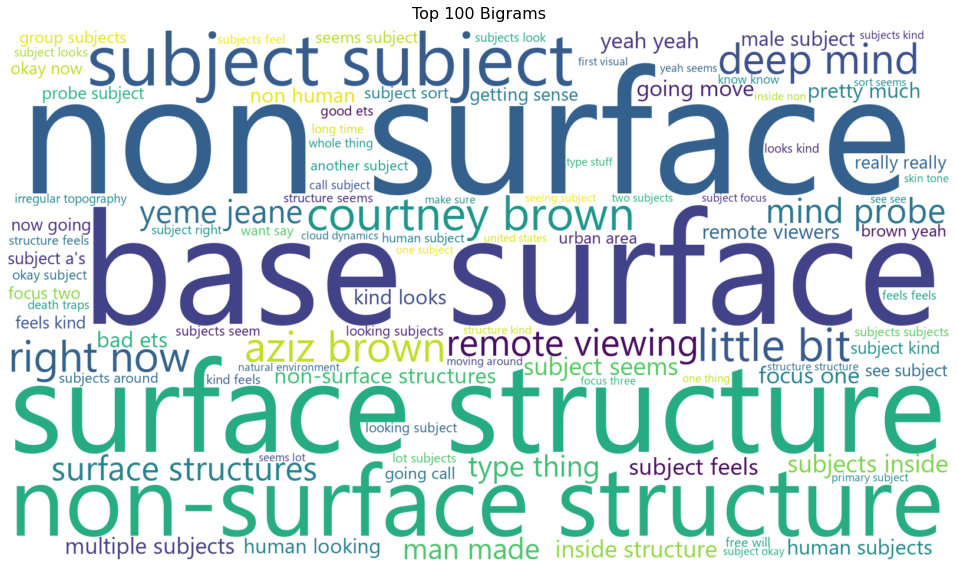

Saved → C:\datasources\farsight_transcripts\farsight_top100_bigrams.png


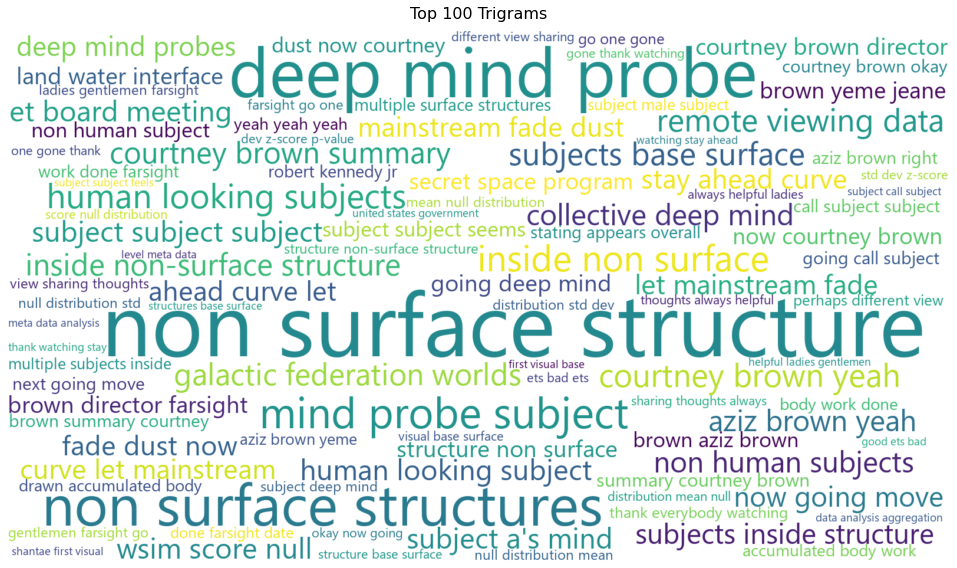

Saved → C:\datasources\farsight_transcripts\farsight_top100_trigrams.png


In [2]:
import re
from collections import Counter
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# --- config (reuse from before) ---
JSON_PATH = Path(r"C:\datasources\farsight_transcripts\farsight_chunks.json")
FONT_PATH = r"C:\Windows\Fonts\segoeui.ttf"  # confirmed TTF
TOP_N = 100

# Base + domain stopwords
STOP = set(STOPWORDS) | {
    "project","overview","session","sessions","target","targets",
    "http","https","www","com","org","net","pdf","txt","amp","nbsp"
}

# Load JSON (array vs NDJSON autodetect)
def load_chunks_json(path: Path) -> pd.DataFrame:
    head = path.read_text(encoding="utf-8", errors="ignore")[:256].lstrip()
    if head.startswith("["):
        return pd.read_json(path, orient="records")
    else:
        return pd.read_json(path, orient="records", lines=True)

df = load_chunks_json(JSON_PATH)

# --- tokenization (same as before) ---
token_re = re.compile(r"[A-Za-z][A-Za-z'-]{1,}")

def tokenize(s: str):
    return [w for w in token_re.findall(s.lower()) if len(w) >= 2 and w not in STOP]

def ngrams(tokens, n):
    for i in range(len(tokens) - n + 1):
        yield tuple(tokens[i:i+n])

# --- count bigrams & trigrams from chunk_text ---
bi = Counter()
tri = Counter()

for text in df["chunk_text"].astype(str):
    toks = tokenize(text)
    # bigrams (skip any phrase containing a stopword — already filtered)
    for g in ngrams(toks, 2):
        bi[" ".join(g)] += 1
    # trigrams
    for g in ngrams(toks, 3):
        tri[" ".join(g)] += 1

# Keep top-N
bi_top = dict(bi.most_common(TOP_N))
tri_top = dict(tri.most_common(TOP_N))

# --- Word clouds (phrases) ---
# Note: we pass phrase->freq dicts; collocations=False so WC won’t auto-merge different bigrams
def plot_phrase_cloud(freqs, title, outfile):
    wc = WordCloud(
        width=1600,
        height=900,
        font_path=FONT_PATH,
        stopwords=STOP,       # harmless here; keys are already phrases
        collocations=False,   # we already built phrases
        background_color="white",
        prefer_horizontal=1.0 # phrases read better horizontally
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(14, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16, pad=12)
    plt.tight_layout()
    plt.show()
    wc.to_file(str(outfile))
    print(f"Saved → {outfile}")

plot_phrase_cloud(bi_top, "Top 100 Bigrams", JSON_PATH.with_name("farsight_top100_bigrams.png"))
plot_phrase_cloud(tri_top, "Top 100 Trigrams", JSON_PATH.with_name("farsight_top100_trigrams.png"))
